# Tutorial Day 1: Introduction to AI in medical imaging (part 2)

During this session we will demonstrate how you can integrate XNAT and `xnatpy` into your research workflow. We will showcase this using a pretrained UNet model that was trained to segment cortical infarcts present on brain MRI scans. For our model we will use MONAI - a collection of libraries built to facilitate machine learning research in medical imaging. For more information about the model you can have a look at the original paper [Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation.](https://arxiv.org/abs/1505.04597) and an introduction to MONAI is available on the framework's [website](https://monai.io/).

[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RISE-MICCAI/AI-in-Medical-Imaging-Winter-2022-School/blob/main/Introduction%20to%20AI%20in%20MI%20(D1)/notebooks/Using%20XNAT%20in%20machine%20learning%20workflows-solutions.ipynb)

In [1]:
# Uncomment if using Google Colab
# !pip install xnat monai==0.6.0
# import os
# os.mkdir("data")
# !wget "https://github.com/RISE-MICCAI/AI-in-Medical-Imaging-Winter-2022-School/raw/main/Introduction%20to%20AI%20in%20MI%20(D1)/notebooks/data/model.pth" -O data/model.pth

In [2]:
# Necessary imports
import os
import matplotlib.pyplot as plt
import xnat

import numpy as np

import torch
from torch.utils.data import DataLoader

import monai
from monai.data import list_data_collate
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsChannelFirstd,
    AsDiscrete,
    Compose,
    LoadImaged,
    ScaleIntensityd,
    ToTensord,
)

import zipfile

Now we will use built-in `UNet` class to create an instance of the model and load the weights of the pretrained model in the newly created instance:

In [3]:
device = torch.device("cpu")
model = monai.networks.nets.UNet(
    dimensions=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2
    ).to(device)

model.load_state_dict(
        torch.load(os.path.join("data", "model.pth"), map_location=torch.device('cpu')))
model.eval();

Now, let's download some sample data that we will use to apply the network to. We have prepared two subjects (`Brain-0001` and `Brain-0002`) that have brain imaging data together with ground truth segmentations in NIfTI format. As we have discussed in the first part of the tutorial, you can associate any kind of data (and not just DICOM data) with an XNAT object. For this demo we have added the files to the subject's resources. Let's download and unzip data from one of the subjects.

In [4]:
with xnat.connect('https://xnat.bmia.nl') as session:
    project = session.projects['sandbox']
    subj = project.subjects['Brain-0002']
    subj.resources['nifti'].download(os.path.join("data", "brain0002.zip"))
    with zipfile.ZipFile(os.path.join("data", "brain0002.zip"),"r") as zip_ref:
        zip_ref.extractall(os.path.join("data"))

  6.1 MiB |        #                                              |   7.2 MiB/s


In order to construct a MONAI dataset that our network will be able to consume, we need to provide the paths to the data in the form of a dictionary:

In [5]:
b02_files = [{"img": os.path.join("data", "Brain-0002/resources/nifti/files/image_flair_mask.nii.gz"), "seg": os.path.join("data", "Brain-0002/resources/nifti/files/image_seg.nii.gz")}]

We also need to instruct the dataset loader how to prepare data, which keys are associated with imaging data, etc. For this application the loader is quite minimal: we simply load the image and the corresponding segmentation, let the loader know which dimension is the channel dimension (so that subsequent transforms interpret it correctly), scale the image intensity, and finally, transform the data into PyTorch tensors. We also define some simple postprocessing (adding sigmoid activation operation to the model output and interpret the output of that as a discrete (0 or 1) value.

In [6]:
transforms = Compose(
        [
            LoadImaged(keys=["img", "seg"]),
            AsChannelFirstd(keys=["img", "seg"], channel_dim=-1),
            ScaleIntensityd(keys="img"),
            ToTensord(keys=["img", "seg"]),
        ]
    )

post_processing = Compose(
    [Activations(sigmoid=True), AsDiscrete(threshold_values=True)]
)

Finally, we can load the dataset:

In [7]:
b02_ds = monai.data.Dataset(data=b02_files, transform=transforms)
loader = DataLoader(b02_ds)

Since the model has been trained on a 96x96x96 windows, we need to apply `sliding_window_inference` method in order to get the prediction for the whole image. We also wrap it and make a higher-order function to simplify the subsequent usage (by omitting the parameters that are constant). In order to test the method performance outside of visual inspection, we will use Dice score.

In [8]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=1,
            predictor=model,
            overlap=0.25,
        )
    return _compute(input)
dice_metric = DiceMetric(include_background=True, reduction="mean")

Now, let's apply the model and visualize its output:

In [9]:
with torch.no_grad():
    image_tensor = b02_ds[0]["img"].unsqueeze(0).to(device)
    segmentation_tensor = post_processing(inference(image_tensor))
    true_segmentation_tensor = b02_ds[0]["seg"].unsqueeze(0).to(device)
    
    dice_score = dice_metric(y_pred=segmentation_tensor, y=true_segmentation_tensor)
    
    image = image_tensor.detach().cpu().numpy()
    segmentation = segmentation_tensor.detach().cpu().numpy()
    true_segmentation = true_segmentation_tensor.detach().cpu().numpy()

print(f"Dice score is: {dice_score.item():.4f}")

Modifying image pixdim from [1.0000057 1.        1.        1.       ] to [  1.0000057    1.           0.99999998 134.67738522]


Dice score is: 0.7574


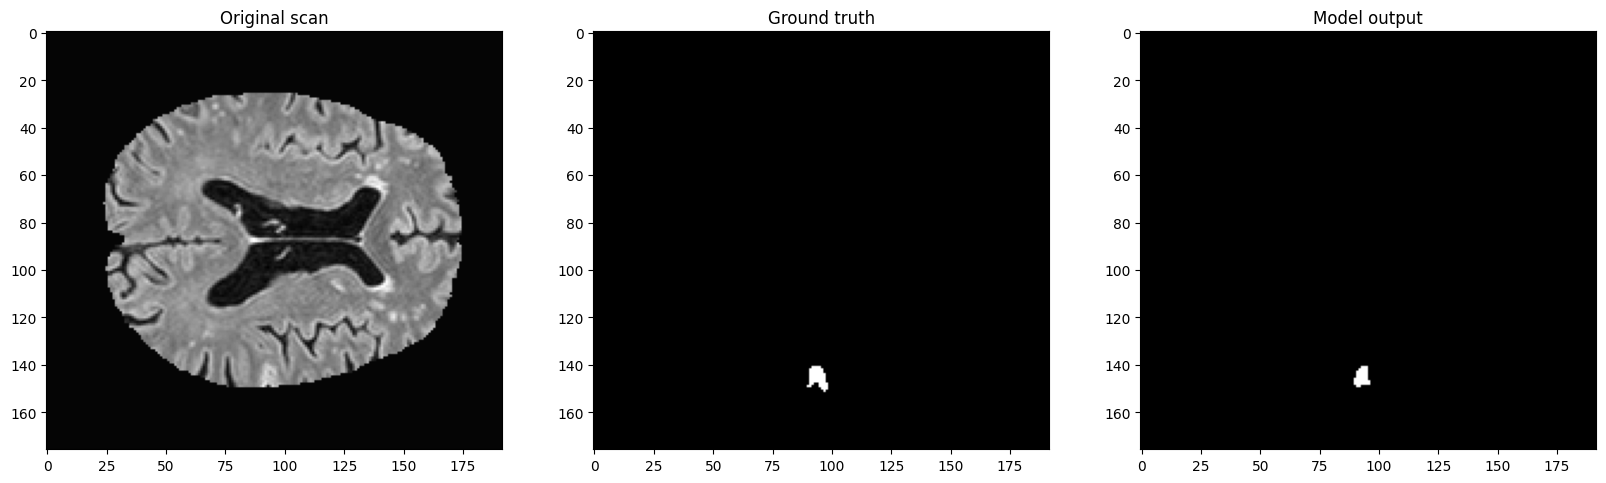

In [10]:
slc = 115

f, axes = plt.subplots(1,3, figsize=(20, 15))
axes[0].imshow(image[0,0,:,:,slc], cmap="gray")
axes[0].title.set_text("Original scan")
axes[1].imshow(true_segmentation[0,0,:,:,slc], cmap="gray")
axes[1].title.set_text("Ground truth")
axes[2].imshow(segmentation[0,0,:,:,slc], cmap="gray")
axes[2].title.set_text("Model output");

Try changing the slice index (`slc`) to see the results on different slices of the scan.
## Exercise 1
Apply the same model to the `Brain-0001` subject and investigate the output similarly to the example above.

In [11]:
with xnat.connect('https://xnat.bmia.nl') as session:
    project = session.projects['sandbox']
    subj = project.subjects['Brain-0001']
    subj.resources['nifti'].download(os.path.join("data", "brain0001.zip"))
    with zipfile.ZipFile(os.path.join("data", "brain0001.zip"),"r") as zip_ref:
        zip_ref.extractall(os.path.join("data"))

  6.2 MiB |       #                                               |   8.7 MiB/s


In [12]:
b01_files = [{"img": os.path.join("data", "Brain-0001/resources/nifti/files/image_flair_mask.nii.gz"), "seg": os.path.join("data", "Brain-0001/resources/nifti/files/image_seg.nii.gz")}]
b01_ds = monai.data.Dataset(data=b01_files, transform=transforms)
loader = DataLoader(b01_ds)

In [13]:
with torch.no_grad():
    image_tensor = b01_ds[0]["img"].unsqueeze(0).to(device)
    segmentation_tensor = post_processing(inference(image_tensor))
    true_segmentation_tensor = b01_ds[0]["seg"].unsqueeze(0).to(device)
    
    dice_score = dice_metric(y_pred=segmentation_tensor, y=true_segmentation_tensor)
    
    image = image_tensor.detach().cpu().numpy()
    segmentation = segmentation_tensor.detach().cpu().numpy()
    true_segmentation = true_segmentation_tensor.detach().cpu().numpy()

print(f"Dice score is: {dice_score.item():.4f}")

Modifying image pixdim from [1.0000073 1.        1.        1.       ] to [  1.00000727   1.00000002   1.00000004 151.58991631]
Modifying image pixdim from [1.0000073 1.        1.        1.       ] to [  1.00000727   1.00000002   0.99999998 151.58992103]


Dice score is: 0.7251


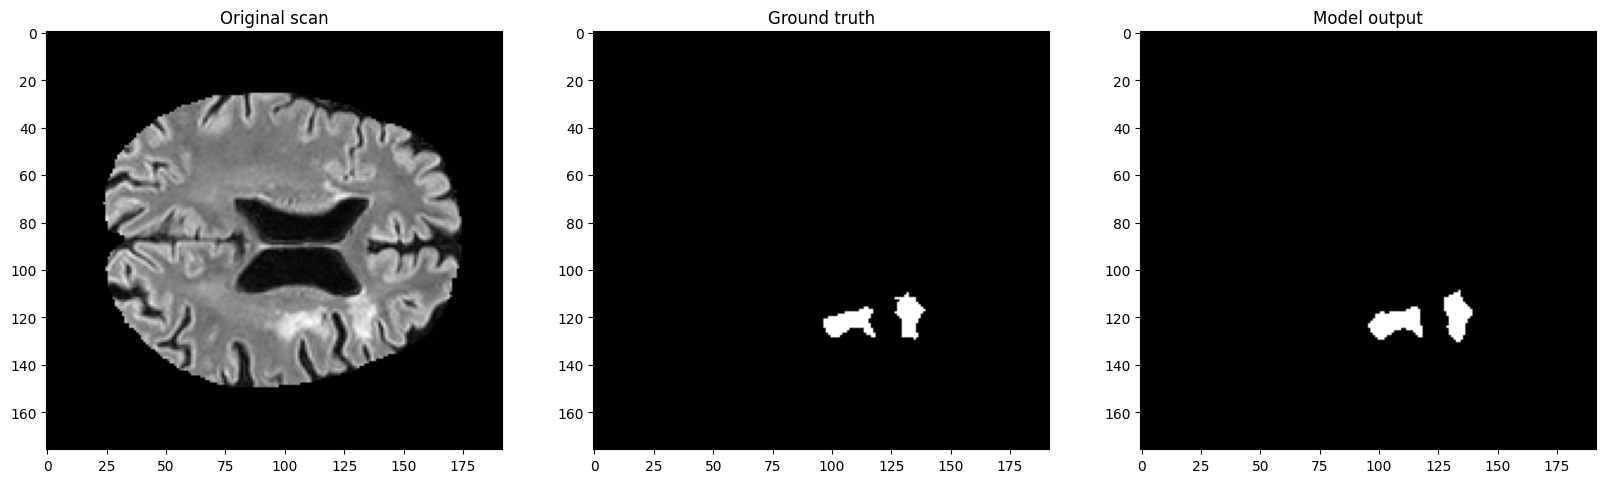

In [14]:
slc = 115

f, axes = plt.subplots(1,3, figsize=(20, 15))
axes[0].imshow(image[0,0,:,:,slc], cmap="gray")
axes[0].title.set_text("Original scan")
axes[1].imshow(true_segmentation[0,0,:,:,slc], cmap="gray")
axes[1].title.set_text("Ground truth")
axes[2].imshow(segmentation[0,0,:,:,slc], cmap="gray")
axes[2].title.set_text("Model output");

**(Optional)** If you have a local installation of XNAT you can upload the resulting segmentation to the corresponding subject using `subj.resources["nifti"].upload` function.